This implementation is from book **Hands on Large Language Models** by Jay Alammar - `Chapter 5`

# Text Clustering
A common pipeline that has gained popularity involves three steps and algorithms:
1. Convert the input documents to embeddings with an `embedding model`.
2. Reduce the dimensionality of embeddings with a `dimensionality reduction model`.
3. Find groups of semantically similar documents with a `cluster model`.

## Loading Dataset (form hugging-face)

### **Error:**

Resolve the Error: ``Invalid pattern: '**' can only be an entire path component``— is caused by a file path issue deep inside fsspec or datasets, likely related to how Hugging Face tries to cache or download the dataset.

```
!pip install --upgrade datasets fsspec aiohttp
```

In [ ]:
!pip install --upgrade datasets fsspec aiohttp

In [10]:
# Load data from Hugging Face
from datasets import load_dataset
dataset = load_dataset("maartengr/arxiv_nlp")["train"]

In [11]:
dataset[10]

{'Titles': 'Bootstrapping Deep Lexical Resources: Resources for Courses',
 'Abstracts': "  We propose a range of deep lexical acquisition methods which make use of\nmorphological, syntactic and ontological language resources to model word\nsimilarity and bootstrap from a seed lexicon. The different methods are\ndeployed in learning lexical items for a precision grammar, and shown to each\nhave strengths and weaknesses over different word classes. A particular focus\nof this paper is the relative accessibility of different language resource\ntypes, and predicted ``bang for the buck'' associated with each in deep lexical\nacquisition applications.\n",
 'Years': 2005,
 'Categories': 'Computation and Language'}

In [ ]:
# Extract metadata
# Extract 'Abstracts' as a list (avoid internal formatting issues)
abstracts = list(dataset["Abstracts"])  # this is the safest way
titles = dataset["Titles"]

In [12]:
abstracts[0]

'  In this paper Arabic was investigated from the speech recognition problem\npoint of view. We propose a novel approach to build an Arabic Automated Speech\nRecognition System (ASR). This system is based on the open source CMU Sphinx-4,\nfrom the Carnegie Mellon University. CMU Sphinx is a large-vocabulary;\nspeaker-independent, continuous speech recognition system based on discrete\nHidden Markov Models (HMMs). We build a model using utilities from the\nOpenSource CMU Sphinx. We will demonstrate the possible adaptability of this\nsystem to Arabic voice recognition.\n'

## Embedding Text Data

In [7]:
from sentence_transformers import SentenceTransformer

# Create an embedding for each abstract
embedding_model = SentenceTransformer("thenlper/gte-small")

Take fewer samples, take 1000 skip 6000 so on ...

In [15]:
len(abstracts), len(titles)

(44949, 44949)

In [16]:
abstracts_sampled = [abstracts[i] for i in range(0, len(abstracts), 7000) for i in range(i, i+1000) if i < len(abstracts)]
titles_sampled =  [titles[i] for i in range(0, len(titles), 7000) for i in range(i, i+1000) if i < len(titles)]

In [18]:
len(abstracts_sampled), len(titles_sampled)

(7000, 7000)

In [25]:
embeddings = embedding_model.encode(abstracts[:5000],show_progress_bar=True)

# Check the dimensions of the resulting embeddings
embeddings.shape

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

(5000, 384)

## Dimentionality Reduction

There are two well known methods for dimentionality reduction
- Principal Component Analysis (PCA)
- Uniform Manifold Approximation and Projection(UMAP).

**Note:** These methods are not perfect. `Information will always be lost with this procedure`. There is a balance between reducing dimensionality and keeping as much information as possible.

In [20]:
from umap import UMAP

# We reduce the input embeddings from 384 dimensions to 5 dimensions - 5 to 10 works best generally.
umap_model = UMAP(
 n_components=5, # number of lower dimensions
 min_dist=0.0,
 metric='cosine',
 random_state=42
)

reduced_embeddings = umap_model.fit_transform(embeddings)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


# Clustering

In [21]:
from hdbscan import HDBSCAN
# We fit the model and extract the clusters
hdbscan_model = HDBSCAN(
  min_cluster_size=50,
  metric="euclidean",
  cluster_selection_method="eom"
).fit(reduced_embeddings)

clusters = hdbscan_model.labels_

# How many clusters did we generate?
len(set(clusters))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


25

### inspecting clusters

In [22]:
import numpy as np

# Print first three documents in cluster 0
cluster = 0
for index in np.where(clusters==cluster)[0][:3]:
 print(abstracts[index][:300] + "... \n")

  This paper describes an approach for automatic construction of dictionaries
for Named Entity Recognition (NER) using large amounts of unlabeled data and a
few seed examples. We use Canonical Correlation Analysis (CCA) to obtain lower
dimensional embeddings (representations) for candidate phrases a... 

  We propose a new method, based on Sparse Distributed Memory (Kanerva
Networks), for studying dependency relations between different syntactic
parameters in the Principles and Parameters model of Syntax. We store data of
syntactic parameters of world languages in a Kanerva Network and we check the
... 

  So far different studies have tackled the sentiment analysis in several
domains such as restaurant and movie reviews. But, this problem has not been
studied in scholarly book reviews which is different in terms of review style
and size. In this paper, we propose to combine different features in or... 



In [27]:
import pandas as pd
# Reduce 384-dimensional embeddings to two dimensions for easier visualization
reduced_embeddings = UMAP(
 n_components=2,
 min_dist=0.0,
 metric="cosine",
 random_state=42
).fit_transform(embeddings)

# reduce titles too:
titles_subset = titles[:len(embeddings)]  # or however you selected embeddings
clusters_df["title"] = titles_subset

# Create dataframe
clusters_df = pd.DataFrame(reduced_embeddings, columns=["x", "y"])
clusters_df["title"] = titles_subset
clusters_df["cluster"] = [str(c) for c in clusters]

# Select outliers and non-outliers (clusters)
to_plot = clusters_df.loc[clusters_df.cluster != "-1", :]
outliers_df = clusters_df.loc[clusters_df.cluster == "-1", :]

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(np.float64(-1.8945641934871675),
 np.float64(9.125706833600997),
 np.float64(-1.1832575708627702),
 np.float64(9.03197377026081))

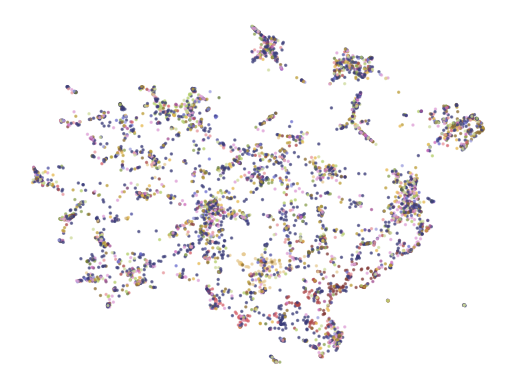

In [28]:
import matplotlib.pyplot as plt
# Plot outliers and non-outliers separately
plt.scatter(outliers_df.x, outliers_df.y, alpha=0.05, s=2,c="grey")

plt.scatter(clusters_df.x, clusters_df.y, c=clusters_df.cluster.astype(int), alpha=0.6, s=2, cmap="tab20b")

plt.axis("off")

## Topic Modeling (BERTopic)

In [ ]:
!pip install bertopic

In [1]:
from bertopic import BERTopic
# Train our model with our previously defined models
topic_model = BERTopic(
 embedding_model=embedding_model,
 umap_model=umap_model,
 hdbscan_model=hdbscan_model,
 verbose=True
).fit(abstracts, embeddings)

NameError: name 'embedding_model' is not defined